## Delta_TL

Using device: cuda


/tmp/ipykernel_740626/898737899.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



OVERALL TEST RESULTS:
  RMSE: 1.8322
  MAE:  1.3408
  R²:   0.9416


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


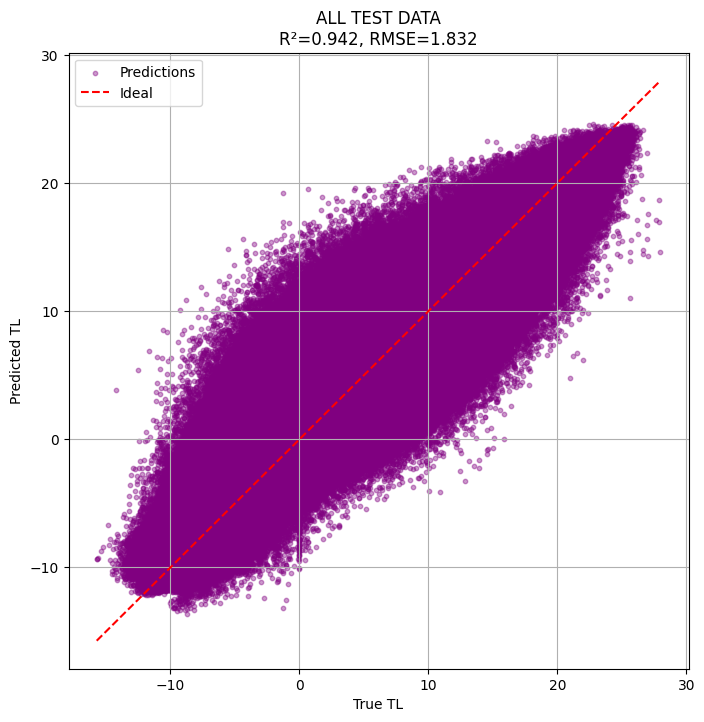

In [2]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# === SETTINGS ===
data_root = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test'
model_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/Model/ann_tl_.pth'
scaler_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/scalersann/ann_tl_.save'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === LOAD MODEL AND SCALER ===
scaler = joblib.load(scaler_path)

class ANN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.Tanh(),
            nn.BatchNorm1d(12),
            nn.Linear(12, 1)
        )
    def forward(self, x):
        return self.net(x)

dummy_input = np.zeros((1, 10), dtype=np.float32)
model = ANN(dummy_input.shape[1]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === FUNCTION TO PREPROCESS INDIVIDUAL FILES ===
def preprocess_file(fp, depth, alb):
    df = pd.read_csv(fp)
    if df.empty or {'Year','Month','Day','Hour','AirTemp','Wind','Tdp','Solar','TL'}.difference(df.columns):
        return None

    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
    df = df.dropna(subset=['Date'])
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['HourOfDay'] = df['Date'].dt.hour
    df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
    df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
    df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

    df = df[['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','TL']].dropna().reset_index(drop=True)
    df['Depth'] = depth
    df['Albedo'] = alb

    return df

# === COLLECT AND CONCATENATE ALL TEST DATA ===
all_test_dfs = []
alb_folders = glob.glob(os.path.join(data_root, 'Alb*'))

for alb_folder in alb_folders:
    alb_match = re.search(r'Alb(\d+)', os.path.basename(alb_folder))
    if not alb_match:
        continue
    alb = int(alb_match.group(1)) / 100.0

    h_folders = glob.glob(os.path.join(alb_folder, 'h*'))
    for h_folder in h_folders:
        h_match = re.search(r'h(\d+)', os.path.basename(h_folder))
        if not h_match:
            continue
        depth = int(h_match.group(1))

        all_files = glob.glob(os.path.join(h_folder, '*.csv'))
        for fp in all_files:
            df = preprocess_file(fp, depth, alb)
            if df is not None:
                all_test_dfs.append(df)

if not all_test_dfs:
    raise ValueError("No valid test data found!")

final_test_df = pd.concat(all_test_dfs, ignore_index=True)

# === SCALING AND TESTING ===
X = final_test_df.drop(columns='TL').values
y_true = final_test_df['TL'].values
X_scaled = scaler.transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy().flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nOVERALL TEST RESULTS:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R²:   {r2:.4f}")

# === SINGLE SCATTER PLOT FOR ALL TEST DATA ===
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.4, s=10, color='purple', label='Predictions')
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal')
plt.xlabel("True TL")
plt.ylabel("Predicted TL")
plt.title(f"ALL TEST DATA\nR²={r2:.3f}, RMSE={rmse:.3f}")
plt.legend()
plt.grid(True)
plt.show()


## CESR (Critical Eigenstress Ratio)

Using device: cuda


/tmp/ipykernel_742014/1472606828.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



OVERALL TEST RESULTS:
  RMSE: 0.0412
  MAE:  0.0299
  R²:   0.9071


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


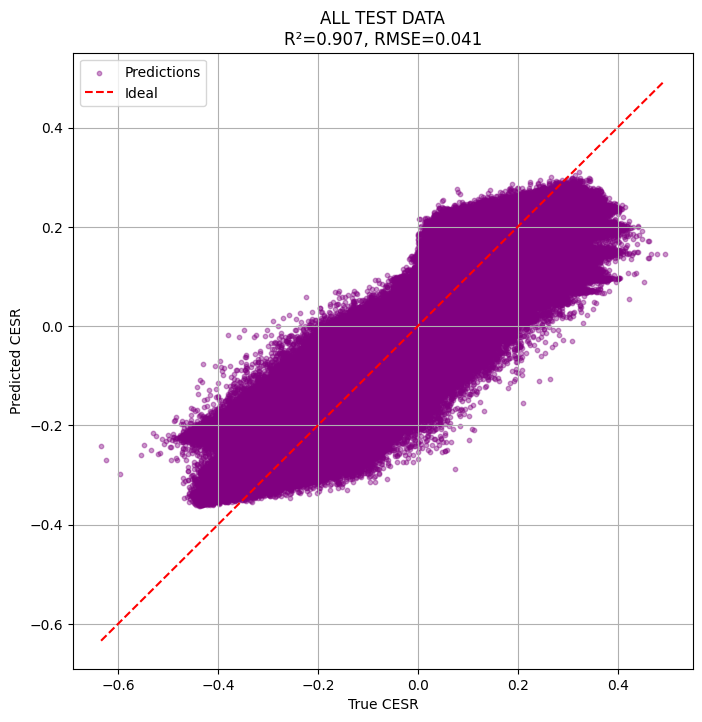

In [2]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# === SETTINGS ===
data_root = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test'
model_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/Model/ann_cesr_.pth'
scaler_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/scalersann/ann_cesr_.save'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === LOAD MODEL AND SCALER ===
scaler = joblib.load(scaler_path)

class ANN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.Tanh(),
            nn.BatchNorm1d(12),
            nn.Linear(12, 1)
        )
    def forward(self, x):
        return self.net(x)

dummy_input = np.zeros((1, 10), dtype=np.float32)
model = ANN(dummy_input.shape[1]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === FUNCTION TO PREPROCESS INDIVIDUAL FILES ===
def preprocess_file(fp, depth, alb):
    df = pd.read_csv(fp)
    if df.empty or {'Year','Month','Day','Hour','AirTemp','Wind','Tdp','Solar','CESR'}.difference(df.columns):
        return None

    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
    df = df.dropna(subset=['Date'])
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['HourOfDay'] = df['Date'].dt.hour
    df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
    df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
    df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

    df = df[['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','CESR']].dropna().reset_index(drop=True)
    df['Depth'] = depth
    df['Albedo'] = alb

    return df

# === COLLECT AND CONCATENATE ALL TEST DATA ===
all_test_dfs = []
alb_folders = glob.glob(os.path.join(data_root, 'Alb*'))

for alb_folder in alb_folders:
    alb_match = re.search(r'Alb(\d+)', os.path.basename(alb_folder))
    if not alb_match:
        continue
    alb = int(alb_match.group(1)) / 100.0

    h_folders = glob.glob(os.path.join(alb_folder, 'h*'))
    for h_folder in h_folders:
        h_match = re.search(r'h(\d+)', os.path.basename(h_folder))
        if not h_match:
            continue
        depth = int(h_match.group(1))

        all_files = glob.glob(os.path.join(h_folder, '*.csv'))
        for fp in all_files:
            df = preprocess_file(fp, depth, alb)
            if df is not None:
                all_test_dfs.append(df)

if not all_test_dfs:
    raise ValueError("No valid test data found!")

final_test_df = pd.concat(all_test_dfs, ignore_index=True)

# === SCALING AND TESTING ===
X = final_test_df.drop(columns='CESR').values
y_true = final_test_df['CESR'].values
X_scaled = scaler.transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy().flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nOVERALL TEST RESULTS:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R²:   {r2:.4f}")

# === SINGLE SCATTER PLOT FOR ALL TEST DATA ===
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.4, s=10, color='purple', label='Predictions')
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal')
plt.xlabel("True CESR")
plt.ylabel("Predicted CESR")
plt.title(f"ALL TEST DATA\nR²={r2:.3f}, RMSE={rmse:.3f}")
plt.legend()
plt.grid(True)
plt.show()


Delta_TL testing on Location Delhi

Using device: cuda


/tmp/ipykernel_858099/927173575.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


RMSE: 1.8068
MAE:  1.3026
R²:   0.9466


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


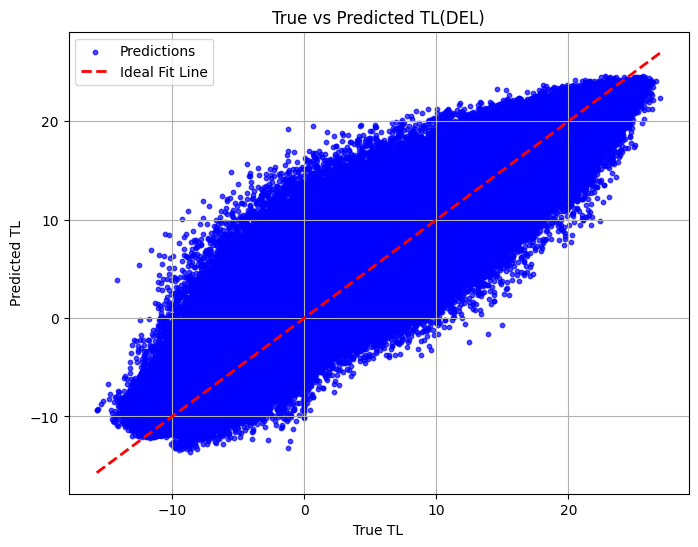

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import joblib
import matplotlib.pyplot as plt

# === SETTINGS ===
model_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/Model/ann_tl_.pth'
scaler_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/scalersann/ann_tl_.save'
test_csv_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/Combined_1961-2022_NH-44-Del.csv'   # <<< CHANGE THIS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === MODEL CLASS (Same as Training) ===
class ANN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.Tanh(),
            nn.BatchNorm1d(12),
            nn.Linear(12, 1)
        )
    def forward(self, x):
        return self.net(x)

# === LOAD TEST CSV ===
df = pd.read_csv(test_csv_path)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

feature_cols = ['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','Depth','Albedo']
if not set(feature_cols).issubset(df.columns):
    raise ValueError("Missing required feature columns in CSV")

X = df[feature_cols].values
y_true = df['TL'].values

# === LOAD SCALER ===
scaler = joblib.load(scaler_path)
X_scaled = scaler.transform(X)

# === LOAD MODEL ===
model = ANN(X.shape[1]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === PREDICTION ===
with torch.no_grad():
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    preds = model(X_tensor).cpu().numpy().flatten()

# === EVALUATION ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# === SCATTER PLOT ===
plt.figure(figsize=(8, 6))
plt.scatter(y_true, preds, alpha=0.7, s=10, color='blue', label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('True TL')
plt.ylabel('Predicted TL')
plt.title('True vs Predicted TL(DEL)')
plt.legend()
plt.grid(True)
plt.show()


delta_TL Testing on Tamil Nadu


Using device: cuda


/tmp/ipykernel_858099/272999111.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


RMSE: 1.8572
MAE:  1.3790
R²:   0.9358


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


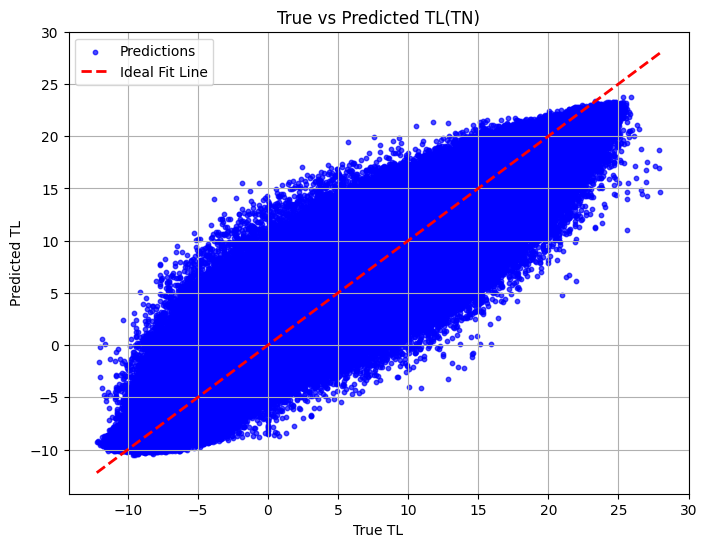

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import joblib
import matplotlib.pyplot as plt

# === SETTINGS ===
model_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/Model/ann_tl_.pth'
scaler_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/scalersann/ann_tl_.save'
test_csv_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/Combined_1961-2022_NH-44-TN.csv'   # <<< CHANGE THIS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === MODEL CLASS (Same as Training) ===
class ANN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.Tanh(),
            nn.BatchNorm1d(12),
            nn.Linear(12, 1)
        )
    def forward(self, x):
        return self.net(x)

# === LOAD TEST CSV ===
df = pd.read_csv(test_csv_path)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

feature_cols = ['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','Depth','Albedo']
if not set(feature_cols).issubset(df.columns):
    raise ValueError("Missing required feature columns in CSV")

X = df[feature_cols].values
y_true = df['TL'].values

# === LOAD SCALER ===
scaler = joblib.load(scaler_path)
X_scaled = scaler.transform(X)

# === LOAD MODEL ===
model = ANN(X.shape[1]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === PREDICTION ===
with torch.no_grad():
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    preds = model(X_tensor).cpu().numpy().flatten()

# === EVALUATION ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# === SCATTER PLOT ===
plt.figure(figsize=(8, 6))
plt.scatter(y_true, preds, alpha=0.7, s=10, color='blue', label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('True TL')
plt.ylabel('Predicted TL')
plt.title('True vs Predicted TL(TN)')
plt.legend()
plt.grid(True)
plt.show()


CESR testing on loc - Del

Using device: cuda


/tmp/ipykernel_858099/1978641566.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


RMSE: 0.039966
MAE:  0.029445
R²:   0.917569


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


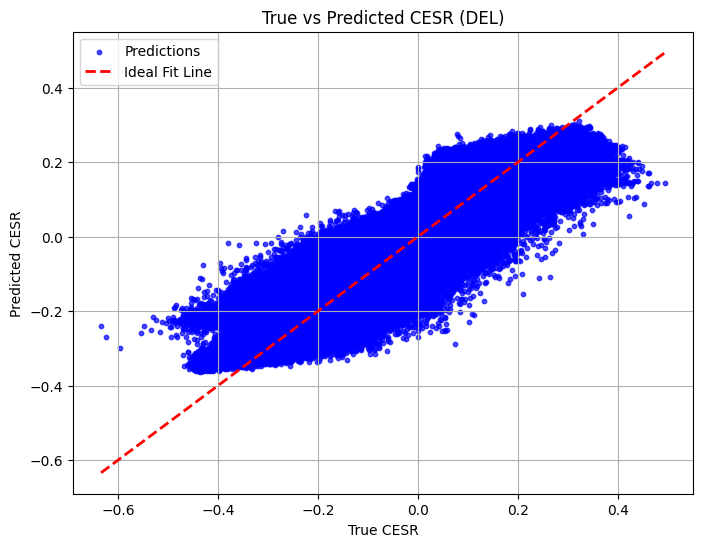

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import joblib
import matplotlib.pyplot as plt

# === SETTINGS ===
model_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/Model/ann_cesr_.pth'  # <-- Changed filename to reflect CESR (optional)
scaler_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/scalersann/ann_cesr_.save'  # <-- Changed filename to reflect CESR (optional)
test_csv_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/Combined_1961-2022_NH-44-Del.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === MODEL CLASS (Same as Training) ===
class ANN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.Tanh(),
            nn.BatchNorm1d(12),
            nn.Linear(12, 1)
        )
    def forward(self, x):
        return self.net(x)

# === LOAD TEST CSV ===
df = pd.read_csv(test_csv_path)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

feature_cols = ['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','Depth','Albedo']
if not set(feature_cols).issubset(df.columns):
    raise ValueError("Missing required feature columns in CSV")

X = df[feature_cols].values
y_true = df['CESR'].values  # <-- changed from 'TL' to 'CESR'

# === LOAD SCALER ===
scaler = joblib.load(scaler_path)
X_scaled = scaler.transform(X)

# === LOAD MODEL ===
model = ANN(X.shape[1]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === PREDICTION ===
with torch.no_grad():
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    preds = model(X_tensor).cpu().numpy().flatten()

# === EVALUATION ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"R²:   {r2:.6f}")

# === SCATTER PLOT ===
plt.figure(figsize=(8, 6))
plt.scatter(y_true, preds, alpha=0.7, s=10, color='blue', label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('True CESR')
plt.ylabel('Predicted CESR')
plt.title('True vs Predicted CESR (DEL)')
plt.legend()
plt.grid(True)
plt.show()


CESR testing on loc - TN

Using device: cuda


/tmp/ipykernel_858099/2996407729.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


RMSE: 0.042414
MAE:  0.030307
R²:   0.895363


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


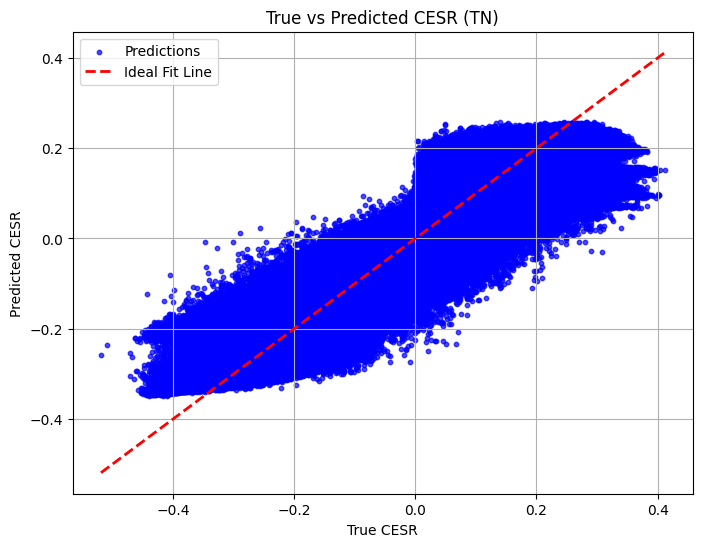

In [8]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import joblib
import matplotlib.pyplot as plt

# === SETTINGS ===
model_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/Model/ann_cesr_.pth'  # <-- Changed filename to reflect CESR (optional)
scaler_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/scalersann/ann_cesr_.save'  # <-- Changed filename to reflect CESR (optional)
test_csv_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/Combined_1961-2022_NH-44-TN.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === MODEL CLASS (Same as Training) ===
class ANN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.Tanh(),
            nn.BatchNorm1d(12),
            nn.Linear(12, 1)
        )
    def forward(self, x):
        return self.net(x)

# === LOAD TEST CSV ===
df = pd.read_csv(test_csv_path)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

feature_cols = ['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','Depth','Albedo']
if not set(feature_cols).issubset(df.columns):
    raise ValueError("Missing required feature columns in CSV")

X = df[feature_cols].values
y_true = df['CESR'].values  # <-- changed from 'TL' to 'CESR'

# === LOAD SCALER ===
scaler = joblib.load(scaler_path)
X_scaled = scaler.transform(X)

# === LOAD MODEL ===
model = ANN(X.shape[1]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === PREDICTION ===
with torch.no_grad():
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    preds = model(X_tensor).cpu().numpy().flatten()

# === EVALUATION ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"R²:   {r2:.6f}")

# === SCATTER PLOT ===
plt.figure(figsize=(8, 6))
plt.scatter(y_true, preds, alpha=0.7, s=10, color='blue', label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('True CESR')
plt.ylabel('Predicted CESR')
plt.title('True vs Predicted CESR (TN)')
plt.legend()
plt.grid(True)
plt.show()
